In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

---

# Data Preprocessing

In [2]:
def loading_and_processing(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    
    labels = []
    texts = []
    for line in lines:
        parts = line.split(' ', 1)
        if len(parts) > 1:
            # we subtact 1 to conver the dataset into a list of [0,1] and not [1,2]
            label = int(parts[0].replace('__label__', '')) - 1
            text = parts[1].strip()
            labels.append(label)
            texts.append(text)
    
    data = pd.DataFrame({'label': labels, 'text': texts})
    
    return data

In [3]:
# Taking a smaller sample size of 50,000 reviews for training, and 10,000 for testing. 
dir = '../Datasets/amazon sentiment analysis'
train_dir = os.path.join(dir, 'train.txt')
test_dir = os.path.join(dir, 'test.txt')

In [4]:
train_data = loading_and_processing(train_dir)

train_data

,label,text
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
49995,0,From M.E. student: This digital caliper sucks!...
49996,1,Amazingly nice for the price! Works great!: I ...
49997,0,Save your money: Not accurate at all. You can ...
49998,1,"great buy...: good price, fast shipping! what ..."


In [5]:
test_data = loading_and_processing(test_dir)

test_data

,label,text
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...
...,...,...
9995,1,Really Enjoyed it!: This was a wonderful read ...
9996,0,Disappointing PC interface/software: The devic...
9997,1,Love it Love it Love it: My daughter loves thi...
9998,0,Faulty leg causing distress for my baby: I pur...


---

# Model Building

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

max_len = 200

# There is not need for train_test_split since we have predefined train and test files
X_train = tokenizer.texts_to_sequences(train_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = train_data['label'].values
y_test = test_data['label'].values

In [7]:
print(f"X_train size: {len(X_train)}, y_train size: {len(y_train)}")
print(f"X_test size: {len(X_test)}, y_test size: {len(y_test)}")

X_train size: 50000, y_train size: 50000
X_test size: 10000, y_test size: 10000


In [8]:
vocab_size = len(tokenizer.word_index) + 1

vocab_size

81162

In [9]:
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     8,116,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,282,921 (31.60 MB)

 Trainable params: 8,282,921 (31.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 295s 188ms/step - accuracy: 0.7827 - loss: 0.4547
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 337s 216ms/step - accuracy: 0.9082 - loss: 0.2360


---

# Model Evaluation

In [11]:
preds = model.predict(X_test)
PREDS = (preds > 0.5).astype(int).flatten()

PREDS

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step


array([1, 1, 0, ..., 1, 0, 1])

In [12]:
unique_values, counts = np.unique(PREDS, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print(f'0 Counts: {value_counts[0]}.')
print(f'1 Counts: {value_counts[1]}.')

0 Counts: 5047.
1 Counts: 4953.


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9017 - loss: 0.2473
Test Accuracy: 0.8976
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4875
           1       0.91      0.88      0.90      5125

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



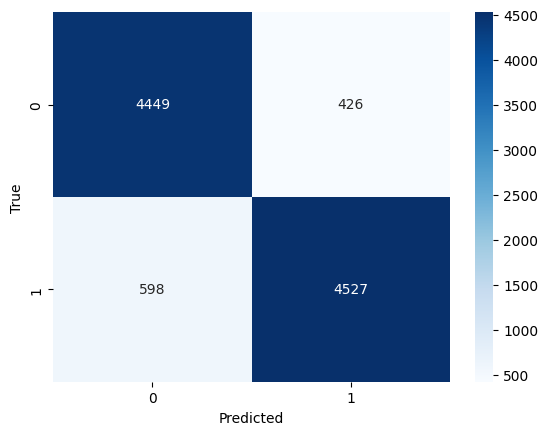

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, zero_division=False))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# Result Analysis

In analyzing the final model’s performance, I focused on its classification accuracy across sentiment classes. The model achieved an overall accuracy of 90.17% during training and 89.76% on the test set. I also examined precision, recall, and F1 score metrics, which revealed that the model performs consistently well with a macro F1 score of 0.90 for both sentiment classes.

The detailed metrics indicated that the model has strong performance for both sentiment classes. Specifically, the precision for class 0 (negative sentiment) was 0.88 and for class 1 (positive sentiment) was 0.91, while the recall was 0.91 and 0.88, respectively. This shows balanced performance, with slight variation in precision and recall between the classes.

Based on these insights, I can refine the model further by focusing on any minor imbalances or enhancing its ability to distinguish between sentiments more precisely.